Our implementation (no moldicts):

In [23]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("..")

In [24]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload 2
import sys
sys.path.append("../..")
from analyses.metrics import *

In [26]:
models = ["Symphony", "Symphony (UFF relaxed)", "EDM", "EDM (UFF relaxed)", "GSchNet", "GSchNet (UFF relaxed)", "GSphereNet", "GSphereNet (UFF relaxed)"]
colors = sns.color_palette("Paired", n_colors=len(models))
model_palette = {model: color for model, color in zip(models, colors)}
model_palette["QM9"] = "black"
model_palette

{'Symphony': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Symphony (UFF relaxed)': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765),
 'EDM': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'EDM (UFF relaxed)': (0.2, 0.6274509803921569, 0.17254901960784313),
 'GSchNet': (0.984313725490196, 0.6039215686274509, 0.6),
 'GSchNet (UFF relaxed)': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 'GSphereNet': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 'GSphereNet (UFF relaxed)': (1.0, 0.4980392156862745, 0.0),
 'QM9': 'black'}

Paths:

In [27]:
generated_paths = {
    "QM9": "/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz",
    # "Symphony_v3_87k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt3_radius_fixed/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=870000/molecules",
    # "Symphony_v3_102k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt3_radius_fixed/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=1020000/molecules",
    # "Symphony_v3_132k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt3_radius_fixed/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=1320000/molecules",
    # "Symphony_v3_330k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt3_radius_fixed/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=3300000/molecules",
    # "Symphony_v4_108k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt4_lower_noise_lower_lr/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=1080000/molecules",
    # "Symphony_v4_222k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt4_lower_noise_lower_lr/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=2220000/molecules",
    # "Symphony_v4_348k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt4_lower_noise_lower_lr/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=3480000/molecules",
    # "Symphony_v4_474k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt4_lower_noise_lower_lr/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=4740000/molecules",
    # "Symphony_v5_132k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt5_lower_lr_0.05noise/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=1320000/molecules",
    # "Symphony_v5_249k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt5_lower_lr_0.05noise/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=2490000/molecules",
    # "Symphony_v6_66k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=660000/molecules",
    # "Symphony_v6_99k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=960000/molecules",
    # "Symphony_v6_132k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=1320000/molecules",
    # "Symphony_v6_372k": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=3720000/molecules",
    "Symphony": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=28980000/molecules",
    "EDM": "/Users/ameyad/Documents/spherical-harmonic-net/others/edm-resampled/samples_edm_xyz",
    "GSchNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gschnet-edm-retrained/molecules",
    "GSphereNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gspherenet/molecules",
}

Corresponding molecules:

In [28]:
all_generated_molecules = {
    model: get_all_molecules(path) for model, path in generated_paths.items()
}

valid_molecules = {
    model: get_all_valid_molecules(molecules) for model, molecules in all_generated_molecules.items()
}

Validity:

QM9: 99.99
QM9: 99.99 +/- 0.00
Symphony: 84.82
Symphony: 84.83 +/- 0.35
EDM: 86.74
EDM: 86.76 +/- 0.34
GSchNet: 74.97
GSchNet: 74.99 +/- 0.42
GSphereNet: 26.92
GSphereNet: 26.95 +/- 0.46


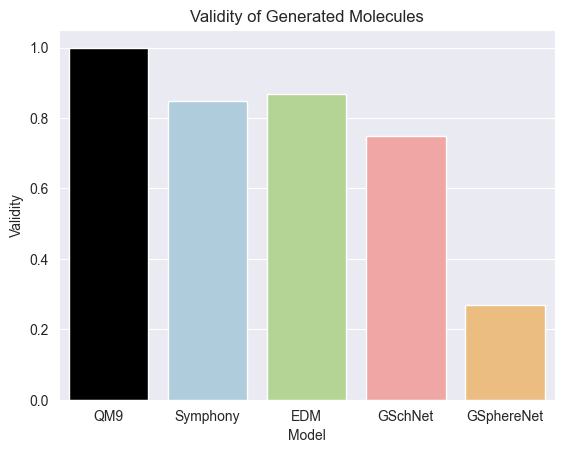

In [29]:
# Make a dataframe for each model for the validity of the molecules.
validity_df = pd.DataFrame(columns=["model", "validity"])

for model, molecules in valid_molecules.items():
    validity_fraction = compute_validity(all_generated_molecules[model], molecules)
    print(f"{model}: {100 * validity_fraction:0.2f}")

    # Compute bootstrap CI for validity
    all_valid_list = jnp.asarray([check_molecule_validity(molecule) for molecule in all_generated_molecules[model]])
    bootstrap_validity_fractions = []
    for rng_seed in range(1000):
        indices = jax.random.choice(jax.random.PRNGKey(rng_seed), len(all_generated_molecules[model]), shape=(len(all_generated_molecules[model]),), replace=True)
        valid = all_valid_list[indices]
        bootstrap_validity_fractions.append(valid.mean())    
    bootstrap_validity_fractions = jnp.array(bootstrap_validity_fractions)
    print(f"{model}: {100 * bootstrap_validity_fractions.mean():0.2f} +/- {100 * bootstrap_validity_fractions.std():0.2f}")
    
    validity_df = pd.concat(
        [
            validity_df,
            pd.DataFrame.from_records(
                {"model": model, "validity": [validity_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=validity_df, x="model", y="validity", palette=model_palette)
plt.title("Validity of Generated Molecules")
plt.xlabel("Model")
plt.ylabel("Validity")
plt.show();

In [30]:
def format_dataframe_and_highlight_minimum(df):
    df_as_str = df.applymap(lambda x: f"{x:.4f}")
    df_with_min = df.applymap(lambda x: f"min{x:.4f}")
    df_formatted = df_with_min.where(df.rank(axis=1, method='min', ascending=True) == 1, df_as_str)
    return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('min')}" + "}" if x.startswith("min") else f"{x}").to_latex(escape=False)

def format_dataframe_and_highlight_maximum(df):
    df_as_str = df.applymap(lambda x: f"{x:.2f}")
    df_with_max = df.applymap(lambda x: f"max{x:.2f}")
    df_formatted = df_with_max.where(df.rank(axis=1, method='max', ascending=False) == 1, df_as_str)
    return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('max')}" + "}" if x.startswith("max") else f"{x}").to_latex(escape=False)

In [31]:
formatted_validity_df = validity_df.transpose()
formatted_validity_df.columns = formatted_validity_df.iloc[0]
formatted_validity_df *= 100
formatted_validity_df = formatted_validity_df.drop("model")
formatted_validity_df.index = ["Validity via \texttt{xyz2mol}"]
formatted_validity_df = formatted_validity_df.astype(float)
formatted_validity_df = formatted_validity_df.round(2)
print(format_dataframe_and_highlight_maximum(formatted_validity_df))

\begin{tabular}{llllll}
\toprule
model &             QM9 & Symphony &    EDM & GSchNet & GSphereNet \\
\midrule
Validity via \texttt{xyz2mol} &  \textbf{99.99} &    84.82 &  86.74 &   74.97 &      26.92 \\
\bottomrule
\end{tabular}



/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_98681/1733903135.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('max')}" + "}" if x.startswith("max") else f"{x}").to_latex(escape=False)


Uniqueness:

QM9: 99.84
Symphony: 97.85
EDM: 99.16
GSchNet: 96.73
GSphereNet: 21.69


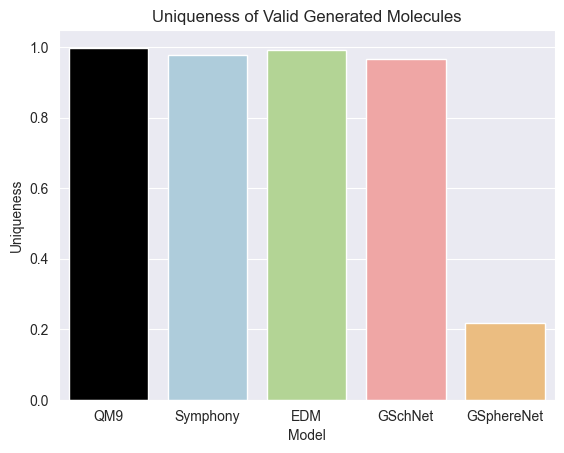

In [32]:
# Make a dataframe for each model for the uniqueness of the molecules.
uniqueness_df = pd.DataFrame(columns=["model", "uniqueness"])

for model, molecules in valid_molecules.items():
    uniqueness_fraction = compute_uniqueness(molecules)
    print(f"{model}: {100 * uniqueness_fraction:0.2f}")
    
    uniqueness_df = pd.concat(
        [
            uniqueness_df,
            pd.DataFrame.from_records(
                {"model": model, "uniqueness": [uniqueness_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=uniqueness_df, x="model", y="uniqueness", palette=model_palette)
plt.title("Uniqueness of Valid Generated Molecules")
plt.xlabel("Model")
plt.ylabel("Uniqueness")
plt.show();

In [33]:
formatted_uniqueness_df = uniqueness_df.transpose()
formatted_uniqueness_df.columns = formatted_uniqueness_df.iloc[0]
formatted_uniqueness_df *= 100
formatted_uniqueness_df = formatted_uniqueness_df.drop("model")
formatted_uniqueness_df.index = ["Uniqueness via \texttt{xyz2mol}"]
formatted_uniqueness_df = formatted_uniqueness_df.astype(float)
formatted_uniqueness_df = formatted_uniqueness_df.round(2)
print(format_dataframe_and_highlight_maximum(formatted_uniqueness_df))

\begin{tabular}{llllll}
\toprule
model &             QM9 & Symphony &    EDM & GSchNet & GSphereNet \\
\midrule
Uniqueness via \texttt{xyz2mol} &  \textbf{99.84} &    97.85 &  99.16 &   96.73 &      21.69 \\
\bottomrule
\end{tabular}



/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_98681/1733903135.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('max')}" + "}" if x.startswith("max") else f"{x}").to_latex(escape=False)


In [34]:
# print("Symphony:")
# for step in [100000, 200000, 500000, 1000000, 2000000, 5000000, "best"]:
#     symphony_molecules_dir_step = generated_paths["Symphony"].replace(
#         "step=best", f"step={step}"
#     )
#     validity_fraction = compute_validity(symphony_molecules_dir_step)
#     print(f" Step {step}: {100 * validity_fraction:0.2f}")

Number of Atoms Per Molecule

In [35]:
molecule_sizes = {
    model: compute_molecule_sizes(molecules) for model, molecules in valid_molecules.items()
}

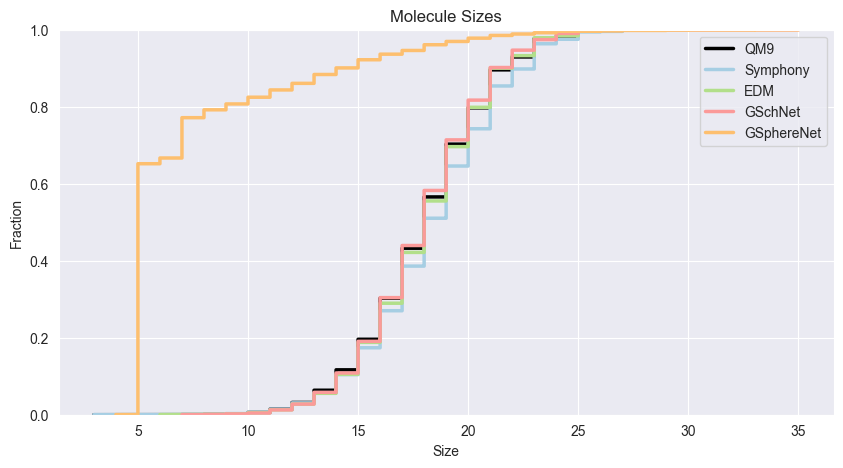

In [36]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
for model in molecule_sizes:
    sns.ecdfplot(data=molecule_sizes[model], label=model, color=model_palette[model], linewidth=2.5, ax=ax)
plt.title(f"Molecule Sizes")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Fraction")
plt.show()

Atom type counts!

In [37]:
atom_type_counts = {
    model: count_atom_types(molecules, normalize=True) for model, molecules in valid_molecules.items()
}

FileNotFoundError: [Errno 2] No such file or directory: '../figures/iclr2024/pngs/atom_type_counts.png'

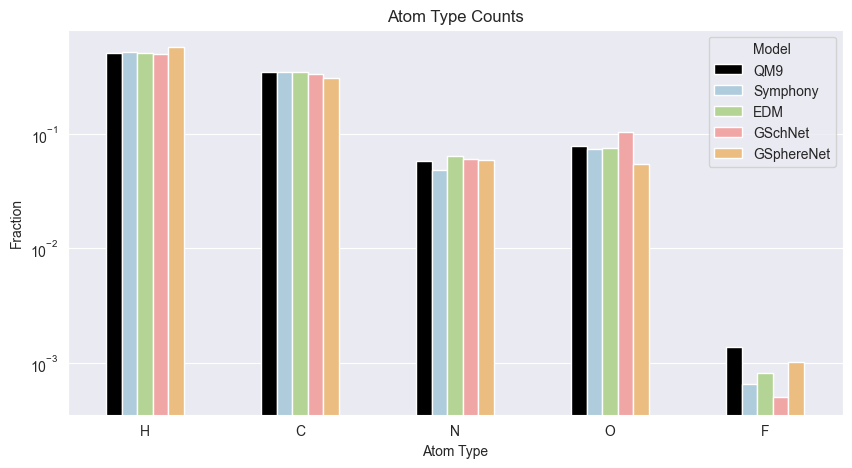

In [38]:
# Make a dataframe of all molecule sizes.
def make_atom_type_counts_df(atom_type_counts) -> pd.DataFrame:
    atom_types = ['H', 'C', 'N', 'O', 'F']
    df = pd.DataFrame(columns=["model", "atom_type", "count"])
    for model in atom_type_counts:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "atom_type": atom_type,
                        "count": atom_type_counts[model].get(atom_type, 0),
                    }
                    for atom_type in atom_types
                ),
            ],
            ignore_index=True,
        )
    return df

atom_type_counts_df = make_atom_type_counts_df(atom_type_counts)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=atom_type_counts_df, x="atom_type", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
plt.title(f"Atom Type Counts")
plt.legend(title="Model")
plt.xlabel("Atom Type")
plt.ylabel("Fraction")
plt.yscale("log")
plt.savefig("../figures/iclr2024/pngs/atom_type_counts.png", dpi=700, bbox_inches="tight")
plt.show()

Local environments:

In [ ]:
local_environments = {
    model: compute_local_environments(molecules, max_num_molecules=1000)
    for model, molecules in valid_molecules.items()
}

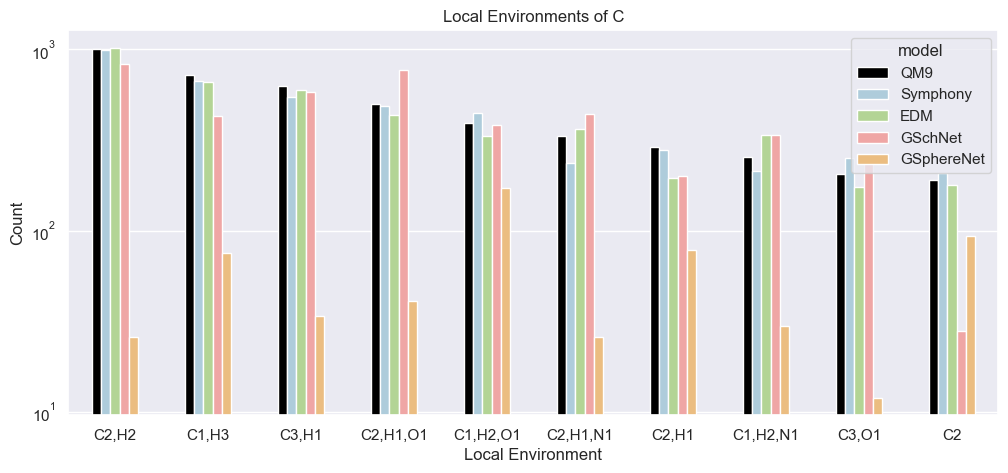

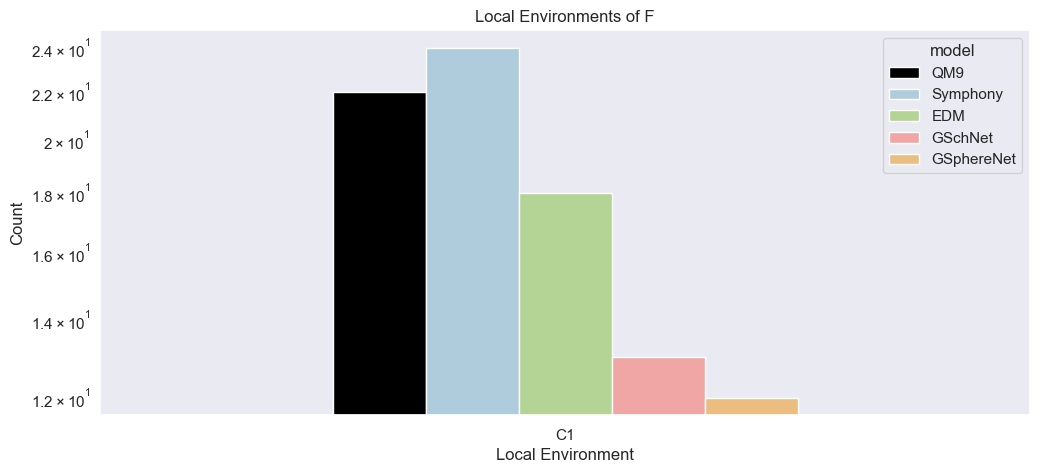

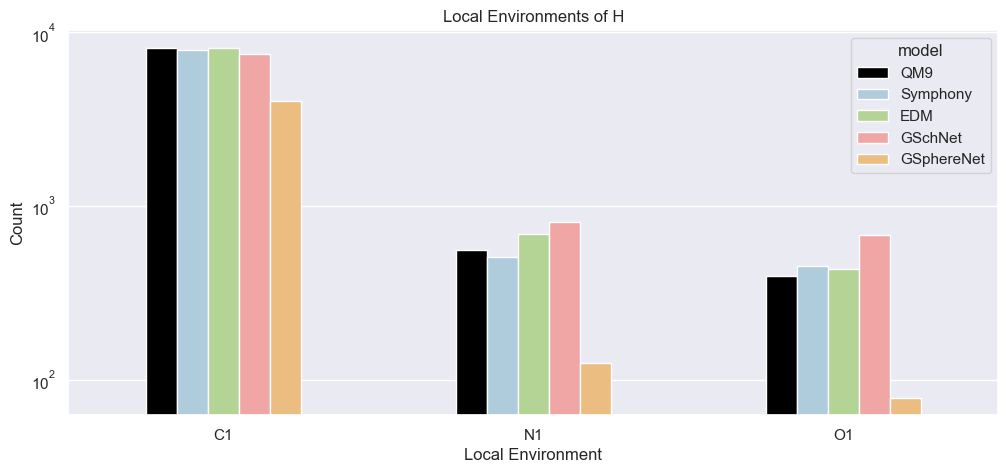

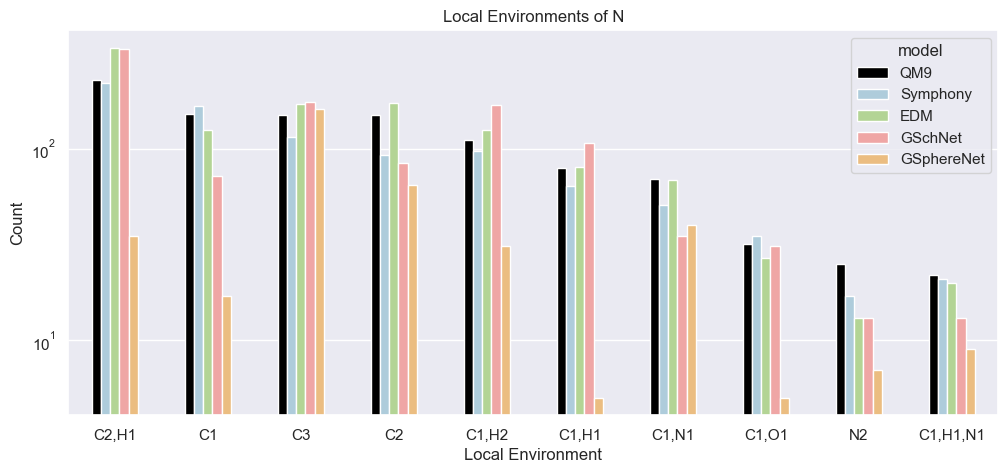

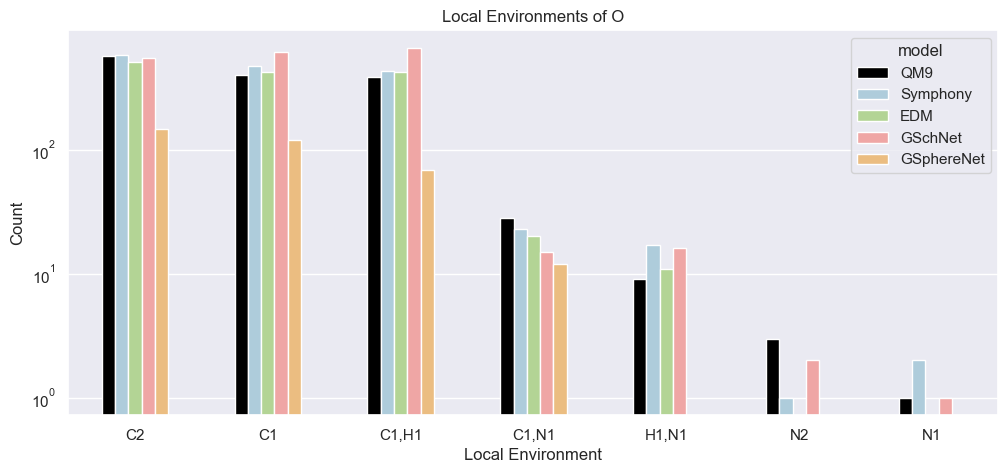

In [ ]:
def make_local_environments_dataframe(central_atom_type: str, max_unique_environments: int) -> pd.DataFrame:
    """Make a dataframe of counts for each of QM9, Symphony and EDM."""
    neighbors = dict(sorted(local_environments["QM9"][central_atom_type].items(), key=lambda x: x[1], reverse=True)[:max_unique_environments])
    df = pd.DataFrame(columns=["model", "neighbors", "count"])
    for model in generated_paths:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "neighbors": neighbor,
                        "count": local_environments[model].get(central_atom_type, {}).get(neighbor, 0),
                    }
                    for neighbor in neighbors
                ),
            ],
            ignore_index=True,
        )
    return df


for central_atom_type in sorted(local_environments["QM9"]):
    local_environments_df = make_local_environments_dataframe(central_atom_type, max_unique_environments=10)

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(data=local_environments_df, x="neighbors", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
    plt.title(f"Local Environments of {central_atom_type}")
    plt.xlabel("Local Environment")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.show()

Bispectra of local environments:

In [ ]:
lmax = 4
max_num_molecules = 1000

bispectra = {}
relative_positions = {}
for model, molecules in valid_molecules.items():
    model_bispectra, model_relative_positions = compute_bispectra_of_local_environments(molecules, lmax, max_num_molecules)
    bispectra[model] = model_bispectra
    relative_positions[model] = model_relative_positions

1000it [01:38, 10.12it/s]
1000it [01:31, 10.94it/s]
1000it [01:29, 11.12it/s]
1000it [01:29, 11.19it/s]
1000it [00:34, 29.01it/s]


In [ ]:
# environments = relative_positions["Symphony"][('C', 'C1,H1')]
# bispectra_for_environment = bispectra["Symphony"][('C', 'C1,H1')]

# sort_indices = np.lexsort(np.round(bispectra_for_environment / 0.0001).T)
# bispectra_for_environment = bispectra_for_environment[sort_indices]
# environments = environments[sort_indices]
# # environments = np.take_along_axis(environments, sort_indices, axis=0)
# # bispectra_for_environment = np.take_along_axis(bispectra_for_environment, sort_indices, axis=0)
# plt.imshow(bispectra_for_environment, cmap="plasma", aspect="auto", interpolation=None, vmin=bispectra_for_environment.min(), vmax=bispectra_for_environment.max())

In [ ]:
# environments_as_ase = [ase.Atoms(
#     positions=np.concatenate([env, np.zeros((1, 3))], axis=0),
#     symbols=['C', 'H', 'C'],
# ) for env in environments]

# plt.imshow(bispectra_for_environment[np.asarray([5, -1])],  vmin=bispectra_for_environment.min(), vmax=bispectra_for_environment.max())

In [ ]:
# nv.show_ase(environments_as_ase[5], gui=True)

In [ ]:
# nv.show_ase(environments_as_ase[-1], gui=True)
# ase.io.write("C:C1,H1-first-environment.xyz", environments_as_ase[0])
# ase.io.write("C:C1,H1-last-environment.xyz", environments_as_ase[-1])

(1008, 15)
(990, 15)
(1018, 15)
(833, 15)
(26, 15)


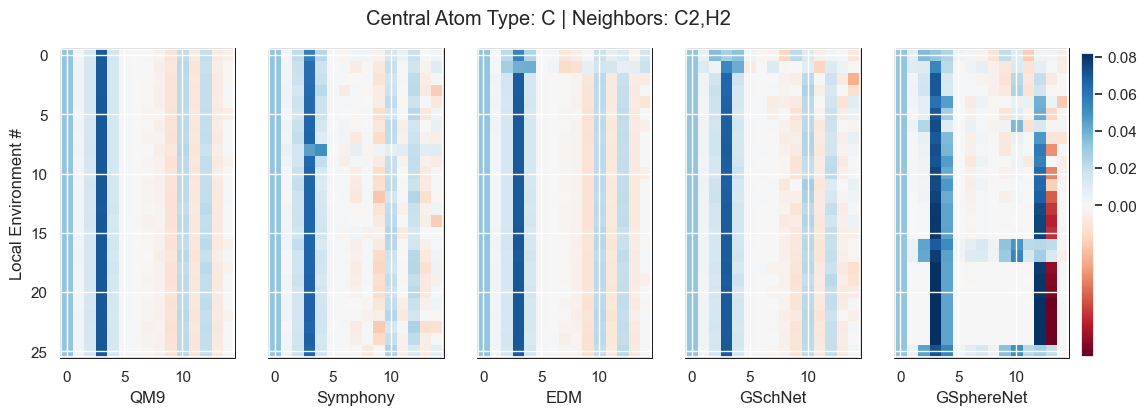

(719, 15)
(671, 15)
(659, 15)
(427, 15)
(75, 15)


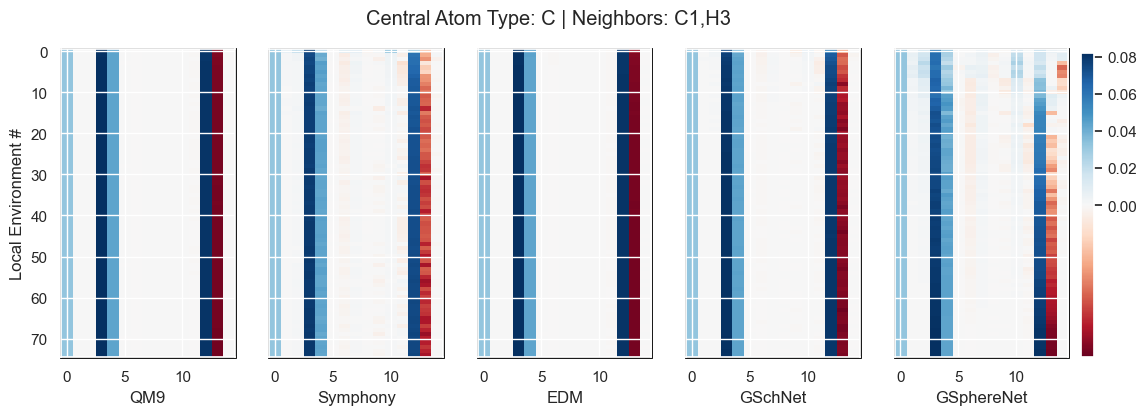

In [ ]:
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


for environment_index, (environment, _) in enumerate(list(sorted_qm9_valid_local_environments_counts.items())[:2]):
    num_models = len(bispectra)
    fig, axs = plt.subplots(ncols=num_models, figsize=(13, 4), sharey=True)

    vmin = np.min(bispectra["QM9"][environment])
    vmax = np.max(bispectra["QM9"][environment])
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=0)

    for index, (model, model_bispectra) in enumerate(bispectra.items()):
        try:
            sort_indices = np.linalg.norm(model_bispectra[environment], axis=-1).argsort()
            model_bispectra_for_environment = model_bispectra[environment][sort_indices]
            mappable = axs[index].imshow(model_bispectra_for_environment, aspect='auto', cmap="RdBu", interpolation=None, norm=norm)
            axs[index].set_xlabel(model)
            axs[index].patch.set_linewidth(2)
            axs[index].patch.set_edgecolor('black')
            # Show colorbar for the last model
            if index == num_models - 1:
                cax = fig.add_axes([.91,.11,.01,.76])
                fig.colorbar(mappable, cax=cax)
                
        except KeyError:
            pass

    central_atom_type, neighbors = environment
    fig.suptitle(f"Central Atom Type: {central_atom_type} | Neighbors: {neighbors}")
    axs[0].set_ylabel("Local Environment #")
    plt.savefig(f"../figures/iclr2024/pngs/bispectra/index={environment_index}-bispectra-{central_atom_type}-{neighbors}.png", dpi=700, bbox_inches="tight")
    plt.show()

MMD (Maximum Mean Discrepancy) of Bispectra:

In [ ]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bispectra = {
    model: compute_maximum_mean_discrepancies(bispectra["QM9"], model_bispectra, rng, batch_size, num_batches)
    for model, model_bispectra in bispectra.items()
    if model != "QM9"
}

In [ ]:
qm9_local_environments_count = {environment: len(bispectra["QM9"][environment]) for environment in bispectra["QM9"]}
qm9_local_environments_count = dict(sorted(qm9_local_environments_count.items(), key=lambda x: qm9_local_environments_count[x[0]], reverse=True))
sorted_qm9_valid_local_environments_counts = {environment: count for environment, count in qm9_local_environments_count.items() if "," in environment[-1]}
sorted_qm9_valid_local_environments_counts

{('C', 'C2,H2'): 1008,
 ('C', 'C1,H3'): 719,
 ('C', 'C3,H1'): 625,
 ('C', 'C2,H1,O1'): 498,
 ('C', 'C1,H2,O1'): 394,
 ('O', 'C1,H1'): 387,
 ('C', 'C2,H1,N1'): 332,
 ('C', 'C2,H1'): 289,
 ('C', 'C1,H2,N1'): 256,
 ('N', 'C2,H1'): 228,
 ('C', 'C3,O1'): 206,
 ('C', 'C1,N1,O1'): 162,
 ('C', 'C1,N1'): 153,
 ('C', 'C2,O1'): 143,
 ('C', 'C1,H1,O1'): 138,
 ('N', 'C1,H2'): 111,
 ('C', 'C1,H1,N1'): 110,
 ('C', 'C1,H1'): 109,
 ('C', 'C3,N1'): 103,
 ('C', 'C2,N1'): 90,
 ('C', 'C1,N2'): 85,
 ('N', 'C1,H1'): 79,
 ('C', 'H3,O1'): 74,
 ('C', 'H3,N1'): 71,
 ('N', 'C1,N1'): 70,
 ('C', 'C1,O2'): 56,
 ('C', 'H1,N1,O1'): 50,
 ('C', 'N2,O1'): 41,
 ('C', 'H1,N2'): 35,
 ('N', 'C1,O1'): 32,
 ('O', 'C1,N1'): 28,
 ('C', 'N1,O2'): 22,
 ('N', 'C1,H1,N1'): 22,
 ('N', 'C2,N1'): 20,
 ('N', 'N1,O1'): 12,
 ('C', 'H2,O2'): 12,
 ('C', 'C1,H1,O2'): 12,
 ('C', 'H1,O2'): 10,
 ('C', 'C2,F1'): 10,
 ('O', 'H1,N1'): 9,
 ('N', 'C1,N2'): 4,
 ('C', 'C2,O2'): 4,
 ('N', 'H1,N2'): 4,
 ('C', 'C1,F1,N1'): 4,
 ('C', 'C1,F3'): 2,
 ('C', '

In [ ]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def environment_as_string(environment: Tuple[str, str]) -> str:
    """Converts an environment to a string."""
    return f"{environment[0]}: {environment[1]}"

mmd_bispectra_df = pd.DataFrame(columns=["model", "environment", "mmd"])
for environment, _ in list(sorted_qm9_valid_local_environments_counts.items())[:10]:
    for model in mmd_bispectra:
        mmd_bispectra_df = pd.concat(
            [
                mmd_bispectra_df,
                pd.DataFrame.from_records(
                    {"model": model, "environment": [environment_as_string(environment)], "mmd": mmd_bispectra[model][environment]}
                ),
            ],
            ignore_index=True,
        )
        
mmd_bispectra_df["mmd"] = mmd_bispectra_df["mmd"].astype(float)

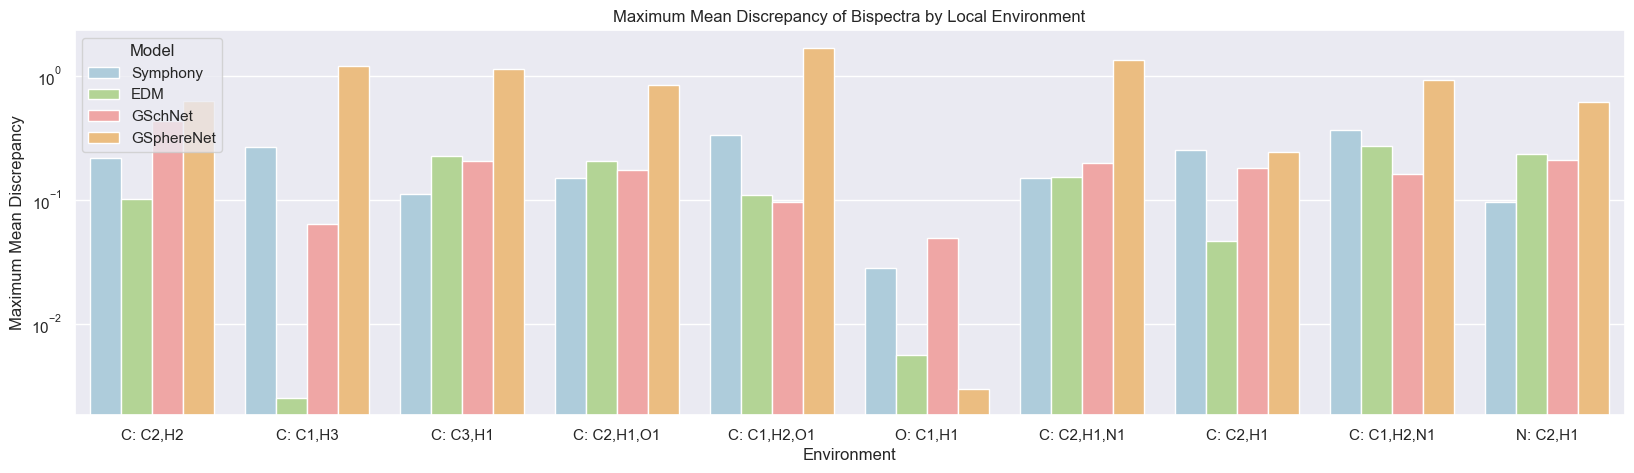

In [ ]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="environment", y="mmd", hue="model", data=mmd_bispectra_df, ax=ax, palette=model_palette)
plt.xlabel("Environment")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bispectra by Local Environment")
plt.show()

Compute all bond lengths:

In [ ]:
bond_dists = {
    model: compute_bond_lengths(molecules)
    for model, molecules in valid_molecules.items()
}

Distribution of Bond Lengths:

In [ ]:
qm9_bond_counts = jax.tree_map(np.size, bond_dists["QM9"])
sorted_qm9_bond_counts = dict(sorted(
    qm9_bond_counts.items(), key=lambda x: x[1], reverse=True
))

print("Bond counts in QM9:")
total_counts = sum(qm9_bond_counts.values())
sum_counts_so_far = 0
for bond_key, count in sorted_qm9_bond_counts.items():
    sum_counts_so_far += count
    print(f"{bond_key }: {count} (cdf: {sum_counts_so_far / total_counts:.3f})")

Bond counts in QM9:
('C', 'H', 1.0): 1103196 (cdf: 0.444)
('C', 'C', 1.0): 662158 (cdf: 0.710)
('C', 'O', 1.0): 188304 (cdf: 0.786)
('C', 'N', 1.0): 139383 (cdf: 0.842)
('H', 'N', 1.0): 73049 (cdf: 0.872)
('C', 'O', 2.0): 55898 (cdf: 0.894)
('C', 'N', 1.5): 55247 (cdf: 0.917)
('H', 'O', 1.0): 52204 (cdf: 0.938)
('C', 'C', 1.5): 43463 (cdf: 0.955)
('C', 'N', 2.0): 20618 (cdf: 0.963)
('C', 'C', 3.0): 19497 (cdf: 0.971)
('C', 'C', 2.0): 17987 (cdf: 0.978)
('C', 'N', 3.0): 17475 (cdf: 0.985)
('C', 'O', 1.5): 14893 (cdf: 0.991)
('N', 'N', 1.5): 10793 (cdf: 0.996)
('N', 'O', 1.5): 4825 (cdf: 0.998)
('C', 'F', 1.0): 3296 (cdf: 0.999)
('N', 'O', 1.0): 2038 (cdf: 1.000)
('N', 'O', 2.0): 177 (cdf: 1.000)
('N', 'N', 3.0): 112 (cdf: 1.000)
('N', 'N', 2.0): 53 (cdf: 1.000)
('N', 'N', 1.0): 16 (cdf: 1.000)


Maximum Mean Discrepancy of Bond Lengths:

In [ ]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bond_lengths = {
    model: compute_maximum_mean_discrepancies(bond_dists["QM9"], model_bond_dists, rng, batch_size, num_batches)
    for model, model_bond_dists in bond_dists.items()
    if model != "QM9"
}

In [ ]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def bond_key_as_string(bond_key: Tuple[int, int, int]) -> str:
    return f"{bond_key[0]}-{bond_key[1]}: {bond_key[2]}"

mmd_bond_lengths_df = pd.DataFrame(columns=["model", "bond_key", "mmd"])
for bond_key, _ in list(sorted_qm9_bond_counts.items())[:10]:
    for model in mmd_bond_lengths:
        mmd_bond_lengths_df = pd.concat(
            [
                mmd_bond_lengths_df,
                pd.DataFrame.from_records(
                    {"model": model, "bond_key": [bond_key_as_string(bond_key)], "mmd": mmd_bond_lengths[model].get(bond_key, 1e9)}
                ),
            ],
            ignore_index=True,
        )

mmd_bond_lengths_df["mmd"] = mmd_bond_lengths_df["mmd"].astype(float)


We have everything we need for the tables:

In [ ]:
def flatten_dict(d: Dict) -> Dict:
    return {
        (key, subkey): value
        for key in d
        for subkey, value in d[key].items()
    }

local_environments_flattened = {
    model: flatten_dict(local_environments[model])
    for model in local_environments
}


def make_jsd_df(counts, index: str) -> pd.DataFrame:
    def normalize_sum(counts):
        return {key: value / sum(counts.values()) for key, value in counts.items()}

    jsd = {}
    for model in counts:
        if model == "QM9":
            continue
        jsd[model] = [compute_jensen_shannon_divergence(normalize_sum(counts["QM9"]), normalize_sum(counts[model]))]
    return pd.DataFrame.from_records(jsd, columns=["Symphony", "EDM", "GSchNet", "GSphereNet"], index=[index])


def reshape_mmd_bond_lengths_df(mmd_bond_lengths_df):
    mmd_bond_lengths_df = mmd_bond_lengths_df.pivot(index="bond_key", columns="model", values="mmd")
    sorted_qm9_bond_counts_formatted = {bond_key_as_string(key): value for key, value in sorted_qm9_bond_counts.items()}
    mmd_bond_lengths_df = mmd_bond_lengths_df.sort_index(ascending=False, key=lambda keys: [sorted_qm9_bond_counts_formatted[key] for key in keys])
    mmd_bond_lengths_df = mmd_bond_lengths_df[[model for model in valid_molecules if model != "QM9"]]
    return mmd_bond_lengths_df


def reshape_mmd_bispectra_df(mmd_bispectra_df):
    mmd_bispectra_df = mmd_bispectra_df.pivot(index="environment", columns="model", values="mmd")
    sorted_qm9_local_environments_formatted = {environment_as_string(key): value for key, value in sorted_qm9_valid_local_environments_counts.items()}
    mmd_bispectra_df = mmd_bispectra_df.sort_index(ascending=False, key=lambda keys: [sorted_qm9_local_environments_formatted[key] for key in keys])
    mmd_bispectra_df = mmd_bispectra_df[[model for model in valid_molecules if model != "QM9"]]
    mmd_bispectra_df.index = mmd_bispectra_df.index.map(lambda x: f"{x}")
    return mmd_bispectra_df

dfs = [
    make_jsd_df(atom_type_counts, "JSD of Atom Type Counts"),
    make_jsd_df(local_environments_flattened, "JSD of Local Environment Counts"),
    reshape_mmd_bond_lengths_df(mmd_bond_lengths_df),
    reshape_mmd_bispectra_df(mmd_bispectra_df),
]
for df in dfs:
    # Highlight the minimum value in each row.
    print(format_dataframe_and_highlight_minimum(df))

# print(mmd_and_jsd_df)
# # Print the best 2 models for each metric.
# print(mmd_and_jsd_df.apply(lambda x: x.nsmallest(2).index.tolist(), axis=1))
# print(mmd_and_jsd_df.apply(lambda x: x.nsmallest(2).tolist(), axis=1))

\begin{tabular}{lllll}
\toprule
{} & Symphony &              EDM & GSchNet & GSphereNet \\
\midrule
JSD of Atom Type Counts &   0.0003 &  \textbf{0.0002} &  0.0011 &     0.0026 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
{} &         Symphony &     EDM & GSchNet & GSphereNet \\
\midrule
JSD of Local Environment Counts &  \textbf{0.0039} &  0.0057 &  0.0150 &     0.1016 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
model &         Symphony &              EDM & GSchNet &       GSphereNet \\
bond_key &                  &                  &         &                  \\
\midrule
C-H: 1.0 &           0.0739 &  \textbf{0.0653} &  0.3817 &           0.1334 \\
C-C: 1.0 &           0.3254 &  \textbf{0.0956} &  0.2530 &           1.0503 \\
C-O: 1.0 &           0.2571 &  \textbf{0.0757} &  0.5315 &           0.6082 \\
C-N: 1.0 &           0.3086 &  \textbf{0.1755} &  0.2999 &           0.4279 \\
H-N: 1.0 &  \textbf{0.1032} &           0.1137 &  0.5968 &          

/Users/ameyad/Documents/spherical-harmonic-net/analyses/../analyses/metrics.py:103: RuntimeWarning: divide by zero encountered in log
  log_p = np.where(p > 0, np.log(p), 0)
/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_33332/1733903135.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('min')}" + "}" if x.startswith("min") else f"{x}").to_latex(escape=False)


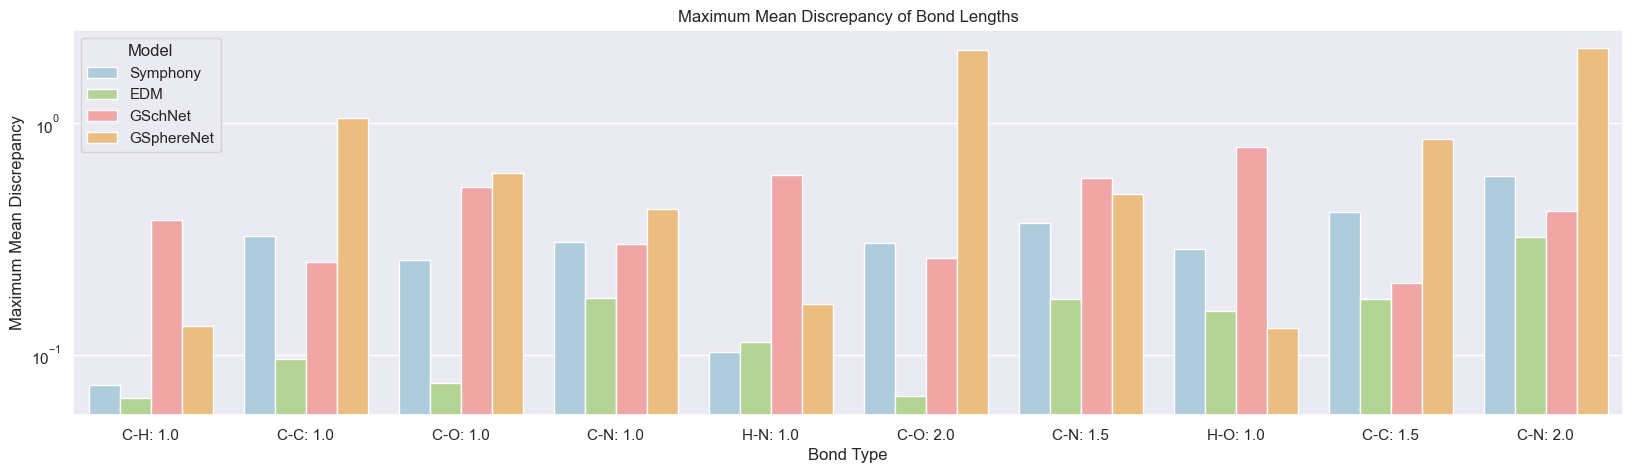

In [ ]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="bond_key", y="mmd", hue="model", data=mmd_bond_lengths_df, ax=ax,
            palette=model_palette)
plt.xlabel("Bond Type")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bond Lengths")
plt.show()

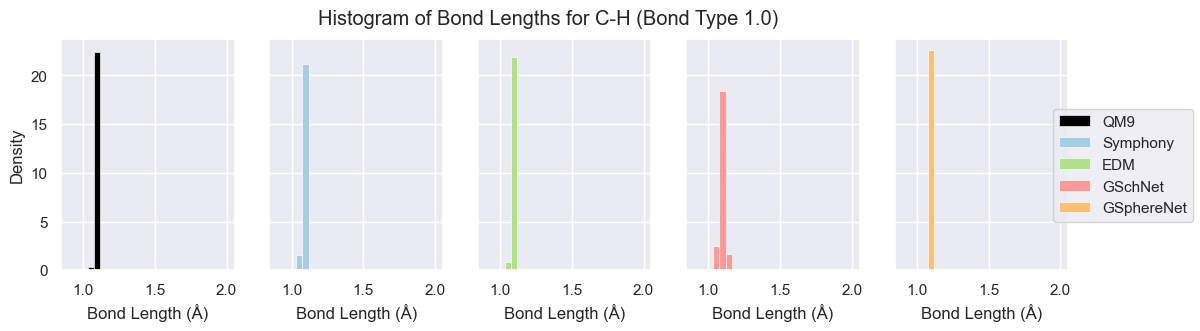

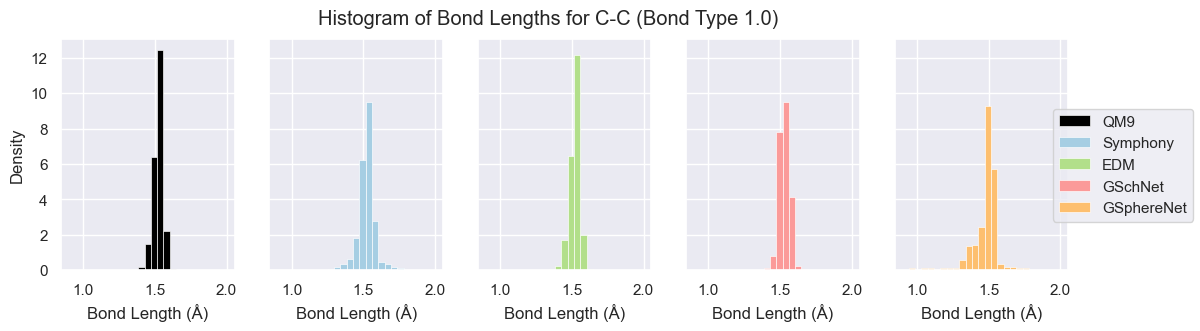

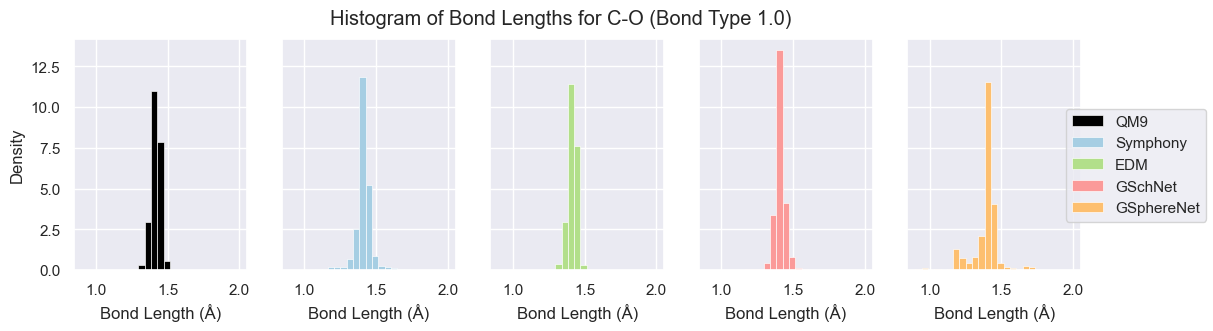

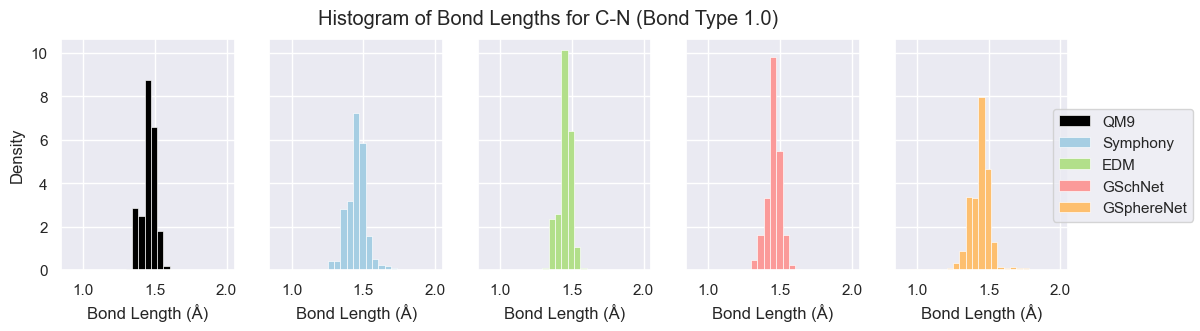

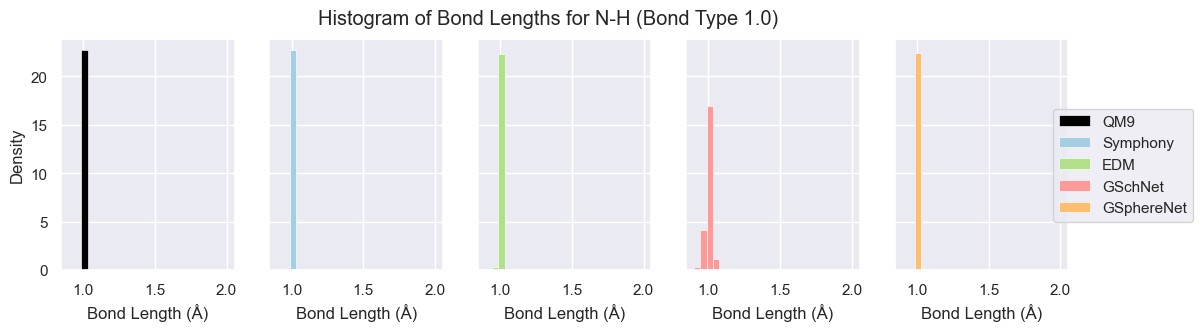

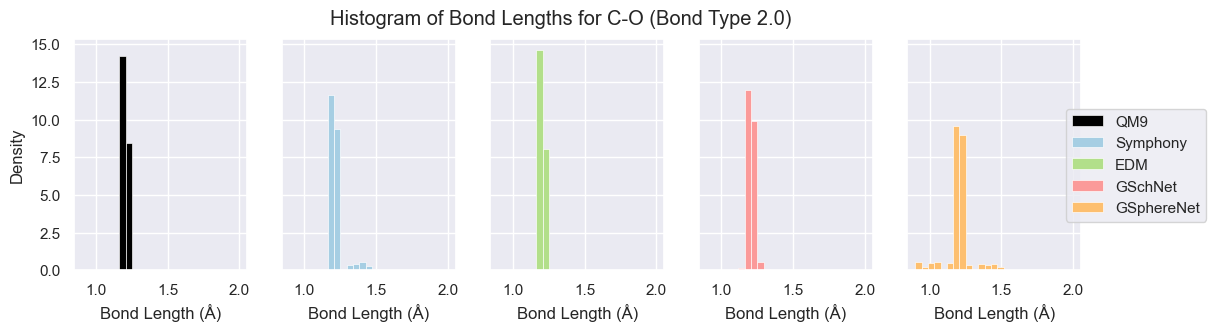

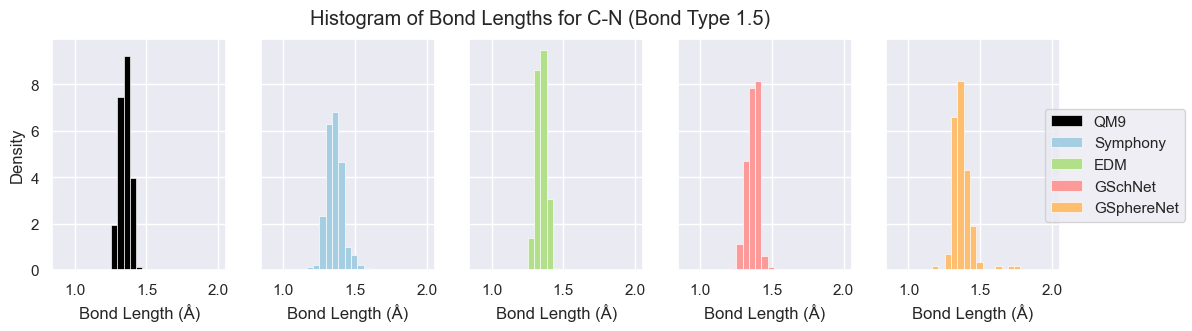

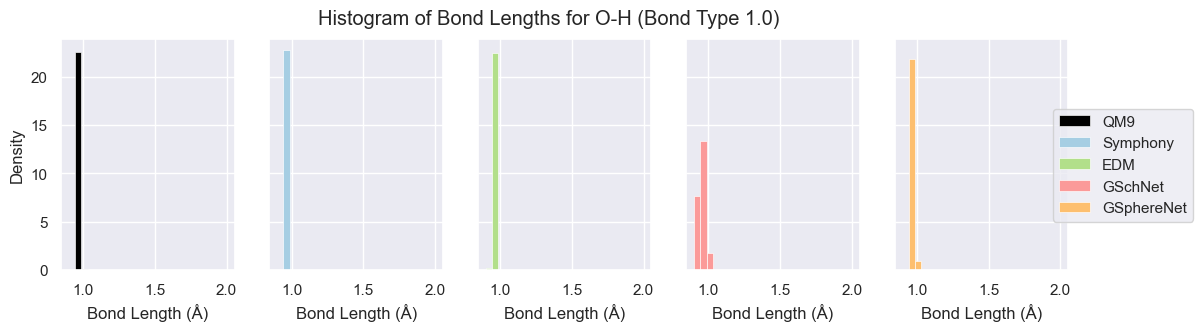

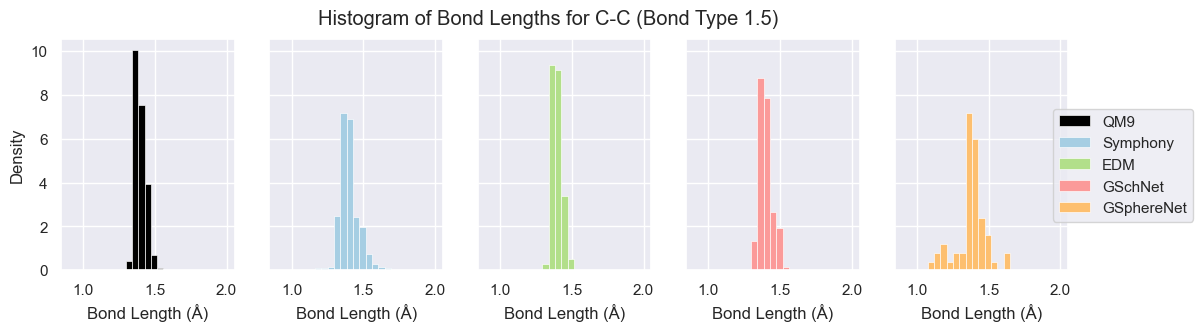

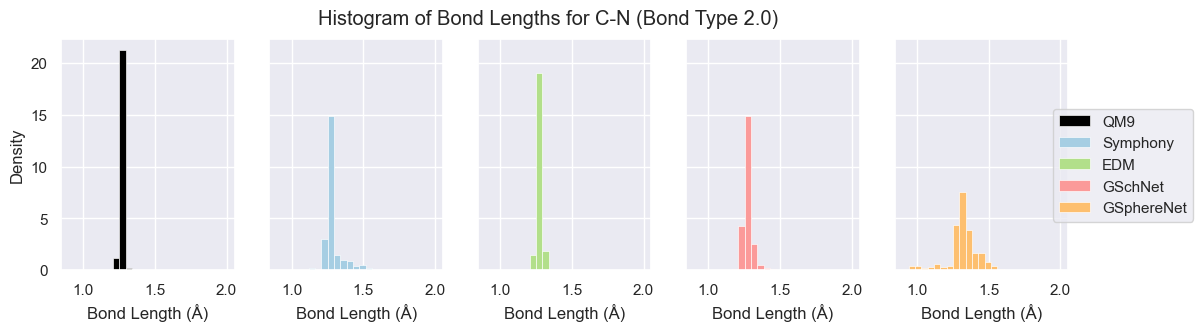

In [ ]:
sns.set_theme(style="darkgrid")
for bond_index, (bond_key, _) in enumerate(list(sorted_qm9_bond_counts.items())[:10]):
    num_models = len(bond_dists)
    fig, axs = plt.subplots(nrows=1, ncols=num_models, figsize=(13, 3), sharex=True, sharey=True)
    for index, model in enumerate(bond_dists):
        try:
            sns.histplot(
                bond_dists[model][bond_key],
                label=model,
                stat="density",
                color=model_palette[model],
                bins=25,
                binrange=(0.9, 2.0),
                ax=axs[index],
                alpha=1,
            )
        except KeyError:
            pass
        axs[index].set_xlabel("Bond Length (Å)")

    atom_type_1, atom_type_2, bond_type = bond_key
    if atom_type_1 == "H":
        atom_type_1, atom_type_2 = atom_type_2, atom_type_1
    fig.suptitle(
        f"Histogram of Bond Lengths for {atom_type_1}-{atom_type_2} (Bond Type {bond_type})"
    )
    fig.legend(loc="center right")
    plt.savefig(f"../figures/iclr2024/pngs/bond_lengths/index={bond_index}-bond-lengths-{atom_type_1}-{atom_type_2}-{bond_type}.png", dpi=700, bbox_inches="tight")
    plt.show()

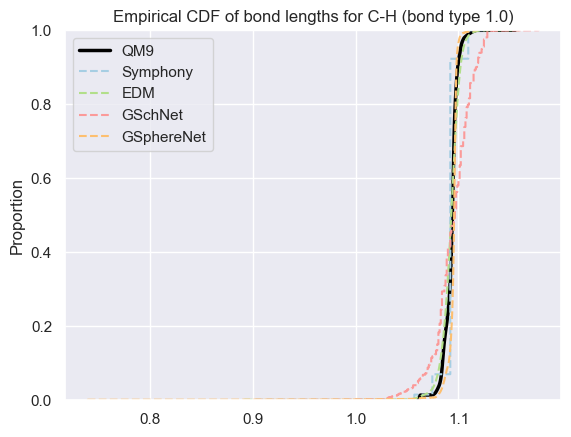

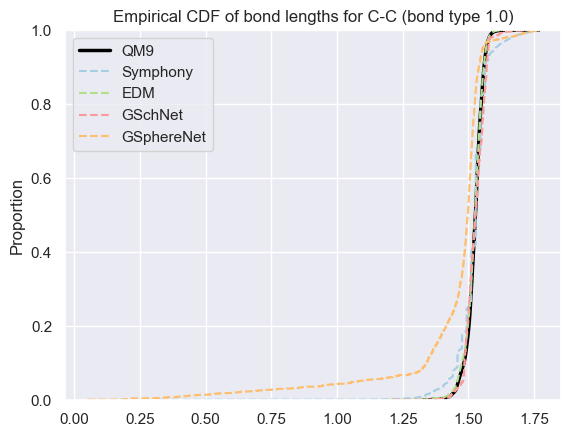

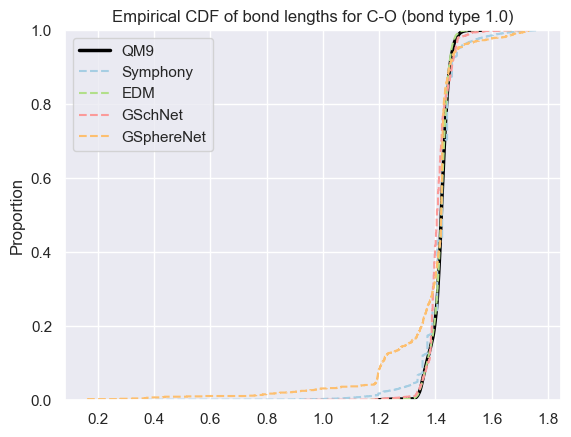

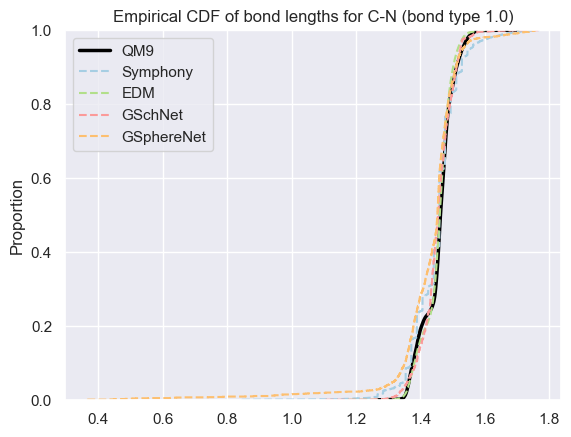

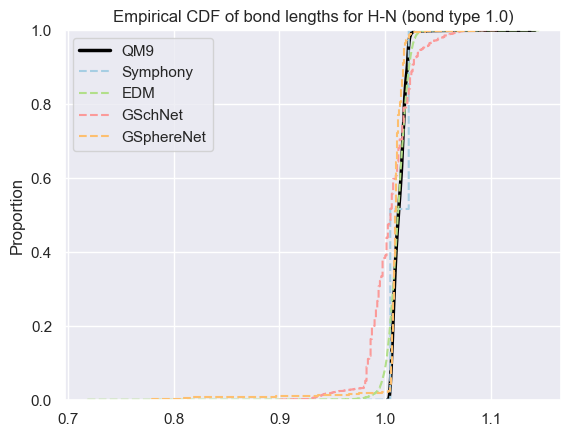

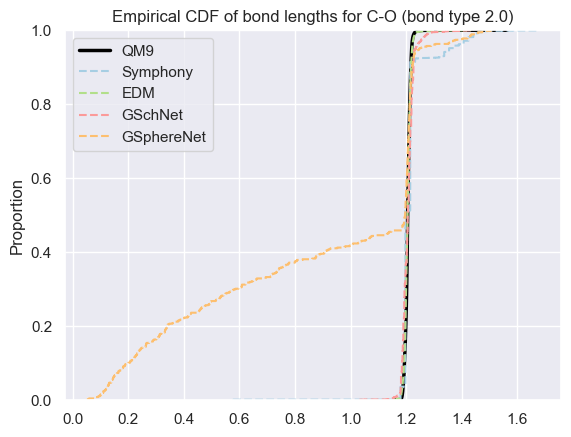

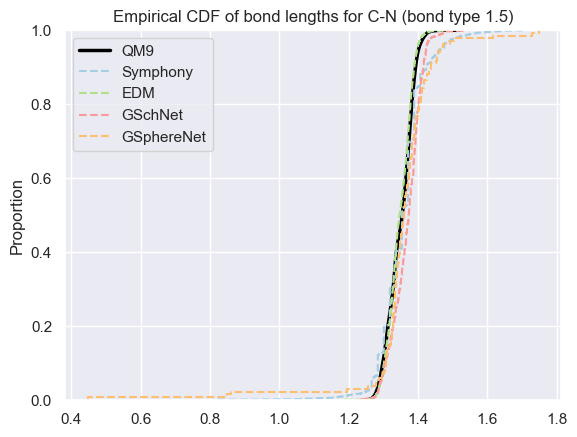

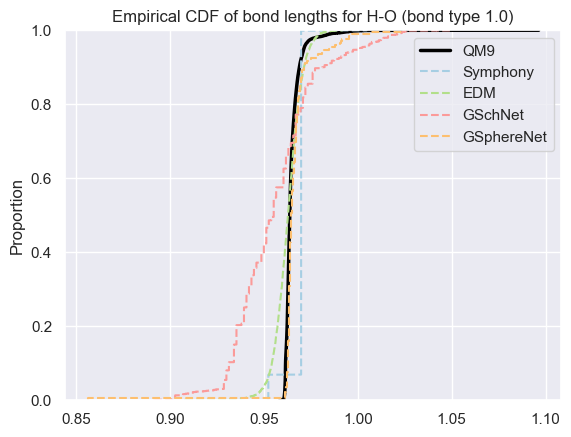

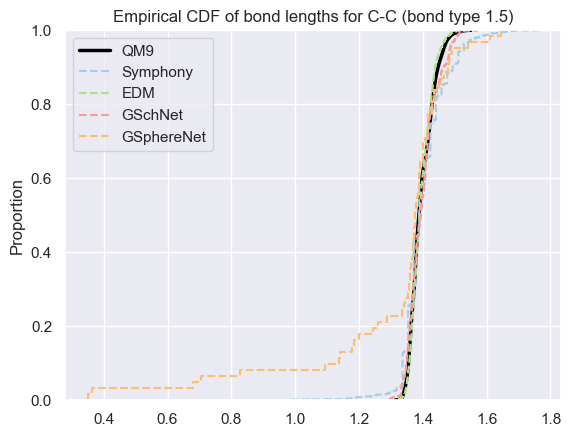

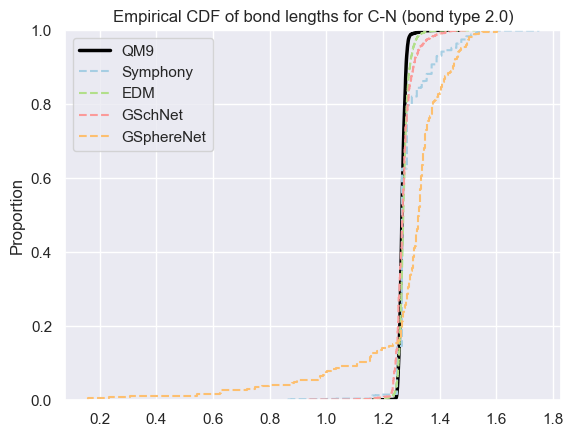

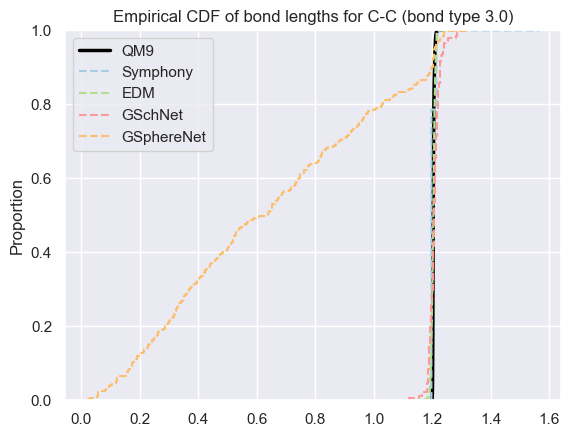

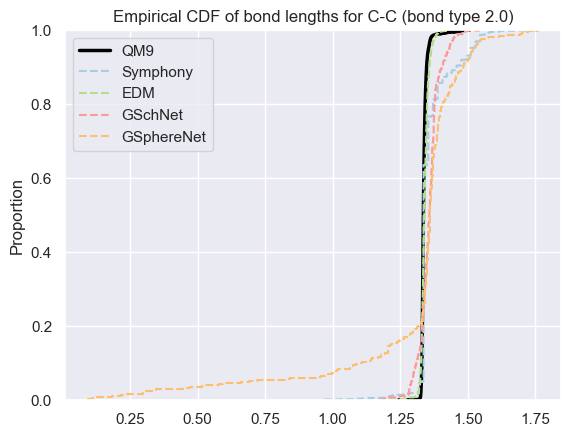

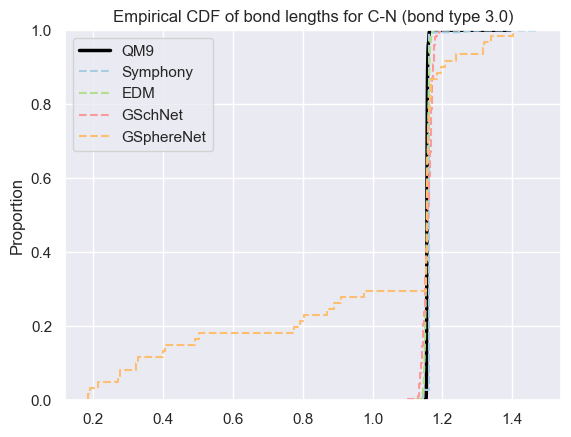

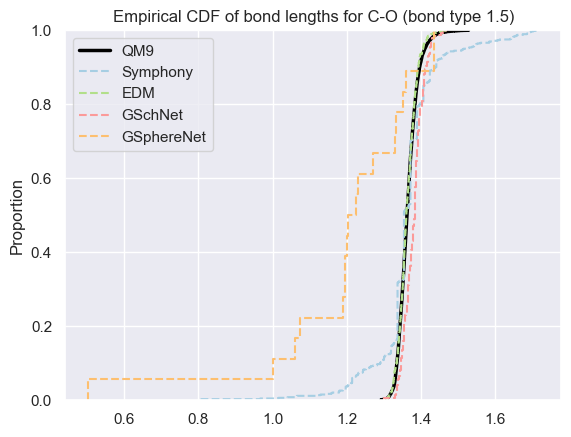

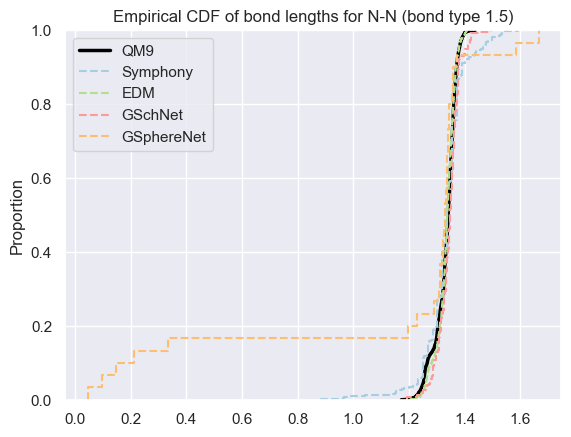

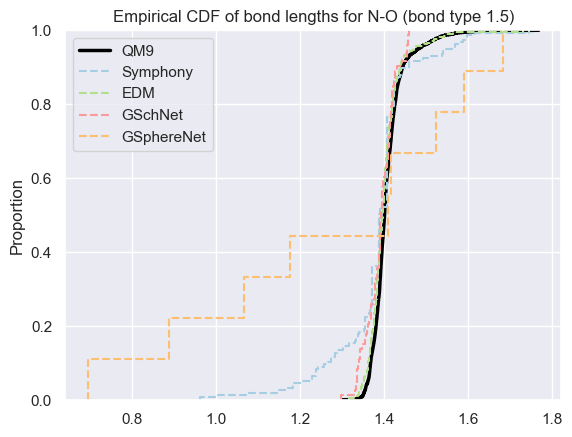

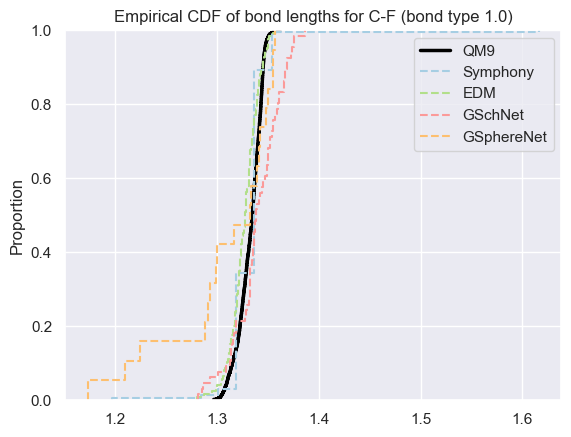

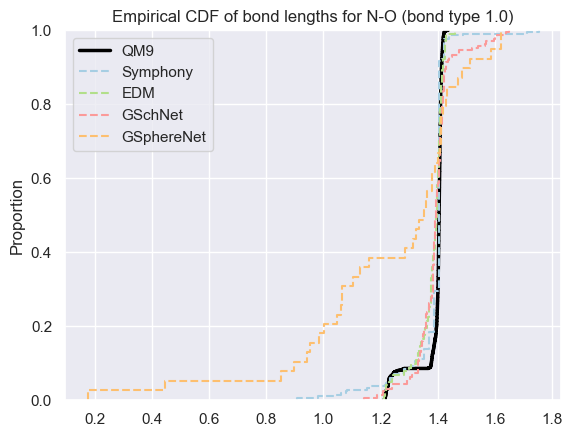

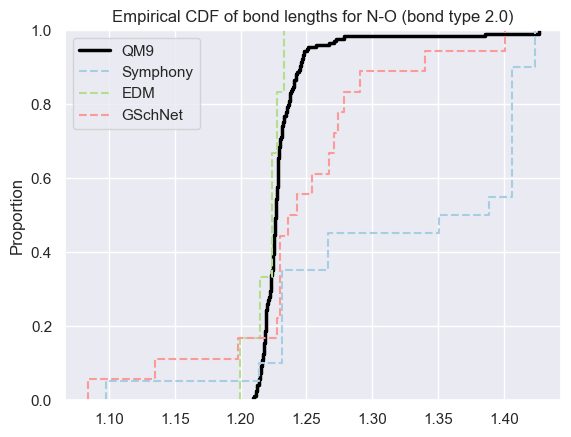

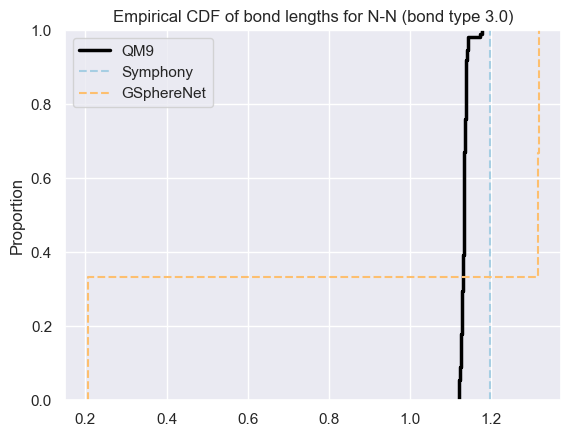

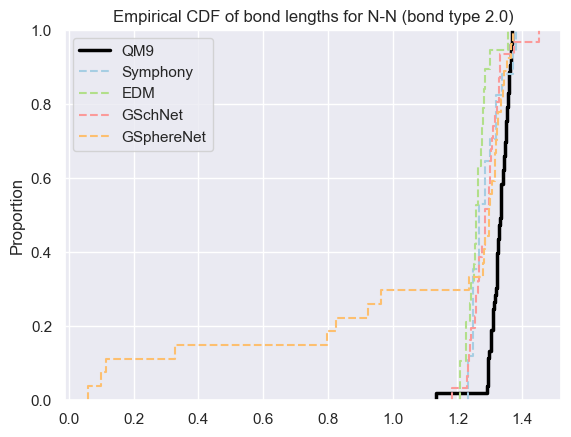

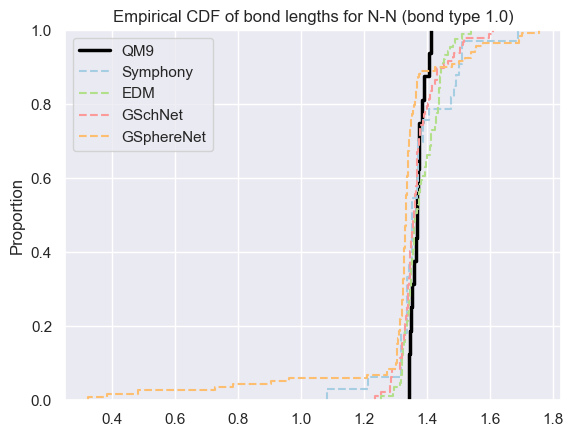

In [ ]:
sns.set_theme(style="darkgrid")
for bond_key, _ in sorted_qm9_bond_counts.items():
    num_models = len(bond_dists)
    for model in generated_paths:
        try:
            if model == "QM9":
                sns.ecdfplot(bond_dists["QM9"][bond_key], label="QM9", color=model_palette[model], linewidth=2.5)
                continue

            sns.ecdfplot(
                bond_dists[model][bond_key],
                label=model,
                linestyle="--",
                color=model_palette[model],
            )
        except KeyError:
            pass

    atom_type_1, atom_type_2, bond_type = bond_key
    plt.title(
        f"Empirical CDF of bond lengths for {atom_type_1}-{atom_type_2} (bond type {bond_type})"
    )
    plt.legend()
    plt.show()

Posebusters!

In [ ]:
posebuster_results = {
    model: get_posebusters_results(molecules)
    for model, molecules in valid_molecules.items()
    if model != "QM9"
}

In [ ]:
posebuster_results_df = pd.DataFrame(columns=["model", "test", "fraction_passed"])
for model in posebuster_results:
    model_results_df = posebuster_results[model].mean()

    # Add a column for the model.
    posebuster_results_df = pd.concat(
        [
            posebuster_results_df,
            pd.DataFrame.from_records(
                {"model": model, "test": model_results_df.index, "fraction_passed": model_results_df.values}
            ),
        ],
        ignore_index=True,
    )

formatted_df = posebuster_results_df.pivot(index="test", columns="model", values="fraction_passed")[list(posebuster_results.keys())]
# Rename index.
def format_index(index: str) -> str:
    index = index.replace("_", " ").title()
    if index == "Bond Angles":
        index = "Reasonable Bond Angles"
    elif index == "Bond Lengths":
        index = "Reasonable Bond Lengths"
    if index == "Internal Steric Clash":
        index = "No Internal Steric Clash"
    if index == "Internal Energy":
        index = "Reasonable Internal Energy"
    return index

formatted_df.index = [
    format_index(index) for index in formatted_df.index
]
formatted_df *= 100
print(format_dataframe_and_highlight_maximum(formatted_df))

\begin{tabular}{lllll}
\toprule
model &        Symphony &              EDM & GSchNet &       GSphereNet \\
\midrule
All Atoms Connected        &           99.92 &            99.88 &   99.87 &  \textbf{100.00} \\
Aromatic Ring Flatness     &          100.00 &           100.00 &   99.95 &            99.85 \\
Reasonable Bond Angles     &           99.56 &   \textbf{99.98} &   99.88 &            97.59 \\
Reasonable Bond Lengths    &           98.72 &  \textbf{100.00} &   99.93 &            72.99 \\
Double Bond Flatness       &  \textbf{99.07} &            98.58 &   97.96 &            95.99 \\
Reasonable Internal Energy &  \textbf{95.65} &            94.88 &   95.04 &            36.07 \\
No Internal Steric Clash   &           98.16 &   \textbf{99.79} &   99.57 &            98.07 \\
Mol Pred Loaded            &          100.00 &           100.00 &  100.00 &           100.00 \\
Sanitization               &          100.00 &           100.00 &  100.00 &           100.00 \\
\bottomrule
\end{tab

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_33332/1733903135.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('max')}" + "}" if x.startswith("max") else f"{x}").to_latex(escape=False)


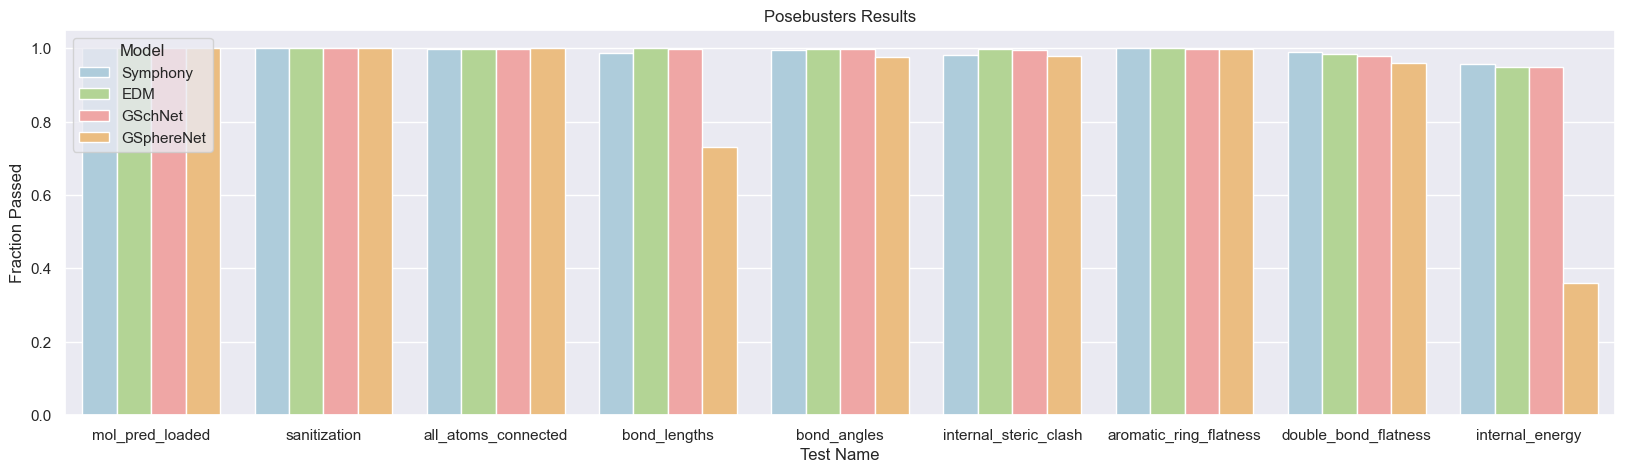

In [ ]:
# Plot each row.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="test", y="fraction_passed", hue="model", data=posebuster_results_df, palette=model_palette, ax=ax)
plt.xlabel("Test Name")
plt.ylabel("Fraction Passed")
plt.legend(title="Model", loc="upper left")
plt.title("Posebusters Results")
plt.show()

In [ ]:
# Print out the best models for each test.
for test in posebuster_results_df["test"].unique():
    print(f"{test}:")
    print(posebuster_results_df[posebuster_results_df["test"] == test].sort_values(by="fraction_passed", ascending=False).head(3))
    print("")

mol_pred_loaded:
       model             test  fraction_passed
0   Symphony  mol_pred_loaded              1.0
9        EDM  mol_pred_loaded              1.0
18   GSchNet  mol_pred_loaded              1.0

sanitization:
       model          test  fraction_passed
1   Symphony  sanitization              1.0
10       EDM  sanitization              1.0
19   GSchNet  sanitization              1.0

all_atoms_connected:
         model                 test  fraction_passed
29  GSphereNet  all_atoms_connected         1.000000
2     Symphony  all_atoms_connected         0.999162
11         EDM  all_atoms_connected         0.998847

bond_lengths:
       model          test  fraction_passed
12       EDM  bond_lengths         1.000000
21   GSchNet  bond_lengths         0.999333
3   Symphony  bond_lengths         0.987186

bond_angles:
       model         test  fraction_passed
13       EDM  bond_angles         0.999769
22   GSchNet  bond_angles         0.998800
4   Symphony  bond_angles         0.

Lipinski Parameters:

In [ ]:
def get_ring_counts(molecules: Sequence[Chem.Mol]) -> Dict[int, int]:
    """Get the counts of rings of each size."""
    counts = collections.defaultdict(int) 
    for mol in molecules:
        for ring in Chem.GetSSSR(mol):
            counts[len(ring)] += 1
    return counts

ring_counts = {
    model: get_ring_counts(molecules)
    for model, molecules in valid_molecules.items()
}
ring_counts


{'QM9': defaultdict(int,
             {3: 62881, 4: 70382, 5: 58792, 6: 18739, 7: 3280, 8: 426, 9: 97}),
 'Symphony': defaultdict(int,
             {4: 3900, 6: 953, 3: 3752, 7: 197, 5: 2991, 8: 16, 9: 1}),
 'EDM': defaultdict(int,
             {4: 3969, 3: 4530, 7: 194, 5: 3696, 6: 1326, 8: 26, 9: 3}),
 'GSchNet': defaultdict(int, {5: 3065, 4: 4561, 6: 891, 3: 4633, 7: 37, 8: 1}),
 'GSphereNet': defaultdict(int,
             {3: 1154, 6: 69, 5: 115, 4: 68, 7: 13, 11: 1, 10: 1, 8: 1})}

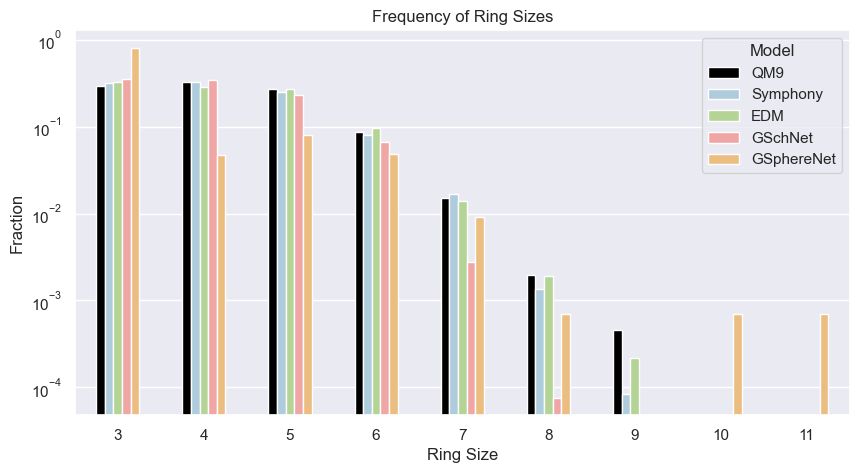

In [ ]:
# Make a dataframe of all ring sizes.
def make_ring_counts_df(ring_counts) -> pd.DataFrame:
    # Normalize the counts for each model.
    normalized_ring_counts = {
        model: {ring: count / sum(counts.values()) for ring, count in counts.items()}
        for model, counts in ring_counts.items()
    }

    # Union of all counts in ring_counts.
    rings = set(key for counts in normalized_ring_counts.values() for key in counts.keys())
    df = pd.DataFrame(columns=["model", "ring", "count"])
    for model in normalized_ring_counts:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "ring": ring,
                        "count": normalized_ring_counts[model].get(ring, 0),
                    }
                    for ring in rings
                ),
            ],
            ignore_index=True,
        )
    return df

ring_counts_df = make_ring_counts_df(ring_counts)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=ring_counts_df, x="ring", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
plt.title("Frequency of Ring Sizes")
plt.yscale("log")
plt.legend(title="Model")
plt.xlabel("Ring Size")
plt.ylabel("Fraction")
plt.savefig("../figures/iclr2024/pngs/ring_sizes.png", dpi=700, bbox_inches="tight")
plt.show()

Some other stuff...

In [ ]:
molecule_dir1 = generated_paths["Symphony"]
molecule_dir2 = generated_paths["Symphony (UFF relaxed)"]
print(compute_validity(molecule_dir1))
print(compute_validity(molecule_dir2))

validity_sum_1 = 0
for molecule_file in os.listdir(molecule_dir1):
    if not molecule_file.endswith(".xyz"):
        continue
    if check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
        validity_sum_1 += 1
        if not check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir1} but not in {molecule_dir2}")

print("done")
validity_sum_2 = 0
for molecule_file in os.listdir(molecule_dir2):
    if not molecule_file.endswith(".xyz"):
        continue
    # print(molecule_file, check_molecule_validity(os.path.join(molecule_dir2, molecule_file)), check_molecule_validity(os.path.join(molecule_dir1, molecule_file)))
    if check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
        validity_sum_2 += 1
        if not check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir2} but not in {molecule_dir1}")

validity_sum_1, validity_sum_2

KeyError: 'Symphony (UFF relaxed)'

Seeing invalid molecules in QM9:

In [ ]:
import ase
import ase.io
import ase.visualize

invalid_mols = []
for molecules_file in os.listdir(qm9_molecules_dir):
    if not molecules_file.endswith(".xyz"):
        continue

    
    molecules_file = os.path.join(qm9_molecules_dir, molecules_file)
    if check_molecule_validity(molecules_file):
        continue

    print(f"{molecules_file} is invalid")
    mol = xyz_to_rdkit_molecule(molecules_file)

    mol = ase.Atoms(
        symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
        positions=mol.GetConformer().GetPositions(),
    )
    invalid_mols.append(mol)
        

In [ ]:
import nglview as nv
v = nv.show_asetraj(invalid_mols, gui=True)
v.add_representation("ball+stick")
v

In [ ]:
suppl = Chem.SDMolSupplier('/Users/ameyad/Documents/spherical-harmonic-net/symphony/data/qm9_data/gdb9.sdf', sanitize=False, removeHs=False)
invalid_sdf_mols = []
for mol in suppl:
    if mol is None:
        continue

    # Try to sanitize molecule.
    # If we could not sanitize, then save the molecules as an ase.Atoms object.
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        mol = ase.Atoms(
            symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
            positions=mol.GetConformer().GetPositions(),
        )
        invalid_sdf_mols.append(mol)
        continue

In [ ]:
v = nv.show_asetraj(invalid_sdf_mols[:50], gui=True)
v.add_representation("ball+stick")
v

# OpenBabel